In [1]:
import os
os.environ["XLA_FLAGS"]="--xla_gpu_autotune_level=0"
from foundry.util.runtime import setup
setup()

import jax
import foundry.core as F
from foundry.core import tree

from policy_eval.common import Result
from policy_eval.methods.diffusion_policy import Checkpoint
checkpoint : Checkpoint = Result.load_s3("s3://wandb-data/uvn050jd/final_result.zarr")

In [2]:
denoiser = checkpoint.create_denoiser()
env, splits = checkpoint.data.load({"train"})
train_data = splits["train"].as_pytree()
train_data = jax.vmap(checkpoint.obs_normalizer.normalize)(train_data.observations)

In [3]:
import foundry
import foundry.core as F
import foundry.random
import foundry.numpy as jnp

In [4]:
@F.jit
def find_datapoint(rng_key):
    def find_candidate(state):
        _, rng_key, _, _ = state
        rng_key, sk = foundry.random.split(rng_key)
        i, j = foundry.random.randint(sk, (2,), minval=0, maxval=tree.axis_size(train_data, 0))
        x, y = jax.tree.map(lambda x: x[i], train_data), \
                jax.tree.map(lambda x: x[j], train_data)
        X, Y = tree.ravel(x)[0], tree.ravel(y)[0]
        valid = jnp.logical_and(i != j, jnp.linalg.norm(X - Y) > 0.05)
        def project(z):
            Z = tree.ravel(z)[0]
            dir = Y - X
            # component along y - x
            along = (jnp.dot(Z - X, dir)*dir)/jnp.sum(jnp.square(dir))
            # component perp to y - x
            away = Z - (X + along)
            return jnp.linalg.norm(along)/jnp.linalg.norm(dir), jnp.linalg.norm(away)
        proj_along, proj_away = F.vmap(project)(train_data)
        valid_projs = jnp.logical_and(proj_along >= 0.1, proj_along <= 0.9)
        distances = jnp.where(jnp.logical_not(valid_projs), proj_away, 100)
        valid = jnp.logical_and(valid, jnp.min(distances) > 0.1)
        return valid, rng_key, i, j

    obs = jax.tree.map(lambda x: x[0], train_data)
    state = False, rng_key, 0, 0
    state= jax.lax.while_loop(
        lambda c: jnp.logical_not(c[0]),
        find_candidate,
        state
    )
    return state[2], state[3]

@F.jit
def find_datapoint(rng_key):
    i = foundry.random.randint(rng_key, (), minval=0, maxval=tree.axis_size(train_data, 0))
    x = jax.tree.map(lambda x: x[i], train_data)
    X = tree.ravel(x)[0]
    def dist(y):
        Y = tree.ravel(y)[0]
        return jnp.sum(jnp.square(X - Y))
    dists = F.vmap(dist)(train_data)
    dists = dists.at[i].set(10000)
    j = jnp.argmin(dists)
    return i, j

pairs = F.vmap(find_datapoint)(foundry.random.split(foundry.random.key(42), 32))

In [5]:
schedule = checkpoint.schedule
def test_interp_sample(rng_key, i, j, alpha):
    a, b = (jax.tree.map(lambda x: x[i], train_data),
            jax.tree.map(lambda x: x[j], train_data))
    obs = jax.tree.map(lambda x, y: alpha*x + (1 - alpha)*y, a, b)
    model = lambda rng_key, x, t: denoiser(obs, rng_key, x, t)
    _, trajectory = checkpoint.schedule.sample(rng_key,
        model,
        checkpoint.actions_structure, 
        trajectory=True
    )
    trajectory = tree.map(lambda x: x[1:], trajectory) # don't include final state
    Ts = jnp.arange(1, schedule.num_steps + 1)

    model = lambda rng_key, x, t: schedule.denoised_from_output(x, t, denoiser(obs, rng_key, x, t))
    interpolator = lambda rng_key, x_noised, t: schedule.denoised_from_output(x_noised, t, tree.map(
        lambda x, y: alpha*x + (1 - alpha)*y,
        denoiser(a, rng_key, x_noised, t),
        denoiser(b, rng_key, x_noised, t)
    ))

    model_evals = jax.vmap(model)(None, trajectory, Ts)
    model_evals = tree.map(lambda x: tree.ravel(x)[0], model_evals)
    interpolator_evals = jax.vmap(interpolator)(None, trajectory, Ts)
    interpolator_evals = tree.map(lambda x: tree.ravel(x)[0], interpolator_evals)
    return jnp.sum(jnp.square(model_evals - interpolator_evals), axis=-1)

@F.jit
def test_interp(alpha):
    rng_keys = foundry.random.split(foundry.random.key(42), tree.axis_size(pairs, 0))
    interp = jax.vmap(test_interp_sample, in_axes=(0, 0, 0, None))(
        rng_keys, pairs[0], pairs[1], alpha
    )
    return interp

alphas = jnp.linspace(0, 1, 20)
errors = jax.vmap(test_interp)(alphas)

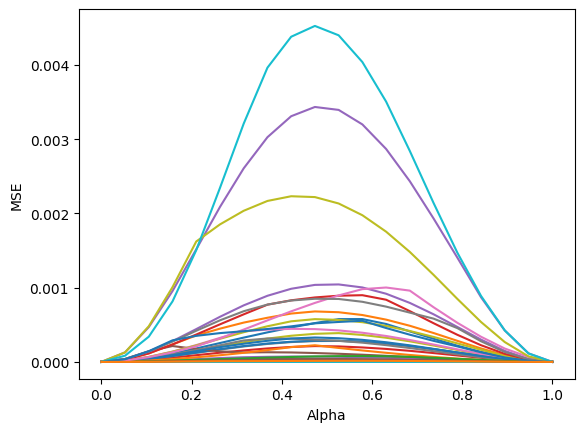

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
plt.plot(alphas, errors)
plt.ylabel("MSE")
plt.xlabel("Alpha")
plt.show()
plt.savefig("interpolation.svg")